Gradient Boosting是一种Boosting的方法，它主要的思想是，每一次建立模型是在之前建立模型损失函数的梯度下降方向。

损失函数是评价模型性能（一般为拟合程度+正则项），认为损失函数越小，性能越好。

而让损失函数持续下降，就能使得模型不断改性提升性能，其最好的方法就是使损失函数沿着梯度方向下降（讲道理梯度方向上下降最快）。

GBDT构建新的特征思想
------------

特征决定模型性能上界，例如深度学习方法也是将数据如何更好的表达为特征。

如果能够将数据表达成为线性可分的数据，那么使用简单的线性模型就可以取得很好的效果。GBDT构建新的特征也是使特征更好地表达数据。

> 主要思想：GBDT每棵树的路径所代表的特征组合直接作为LR的输入特征使用。
> 
> 用已有特征训练GBDT模型，然后利用GBDT模型学习到的树来构造新特征，最后把这些新特征加入原有特征一起训练模型。

> 构造的新特征向量是取值0/1的，向量的每个元素对应于GBDT模型中树的叶子结点。
>
> 当一个样本点通过某棵树最终落在这棵树的一个叶子结点上，那么在新特征向量中这个叶子结点对应的元素值为1，而这棵树的其他叶子结点对应的元素值为0。新特征向量的长度等于GBDT模型里所有树包含的叶子结点数之和。

![x](https://img-blog.csdnimg.cn/2e94dc27e3de4cfe94aef84985961ac3.png)

如上图，假设GBDT使用了2个决策树作为弱学习器。

其中第一颗树有3个叶子节点$l^1_1,l^2_1,l^3_1$，第二颗树有2个叶子节点$l^1_2,l^2_2$，那么我们就为样本生成一个5维的新特征。

若样本在第一颗树中属于叶子1，在第二颗树中属于叶子2，则该样本在新特征中的值为[1,0,0,0,1]，在第1个维度和第5个维度上有值，其他维度没有值。

**含义：决策树中的叶子节点代表了样本具有某种属性组合，这种属性组合由于很有意义所以才会存在决策树中（不然就会被剪支掉）。**

**比如广告点击中广告属性（国家、节日）这种特征，（中国-春节）和（美国-感恩节）是有意义的特征组合。**

**我们将所有有意义的特征组合提取出来作为一个新的特征，这就是gbdt构建新特征的目的。**

因为每种有意义的特征组合，这种组合的意义有多大是不知道的，所以需要重新将特征组合作为新特征来训练模型。

训练出每种特征组合的意义权重，进而对样本包含的多重有效组合进行计算结果。

用下面的例子更好理解一些，比如现在知道一批有意义的特征组合。其中$x^i_j$表示第j个特征取第i个该特征的可取值。

| 特征取值组合 | 组合有效性|
|--|--|
| $x^1_1$、$x^1_2$、$x^1_3$ | $w_1$ |
| $x^1_1$、$x^3_2$ | $w_2$ |
| $x^2_1$、$x^3_3$ | $w_3$ |
| $x^4_1$、$x^6_2$ | $w_4$ |

GBDT的叶子节点就代表有效的特征组合。我们需要求的就是$w_1$、$w_2$、$w_3$、$w_4$。这个可以用lr或者fm求解。

GBDT与LR融合案例
--

所以这个过程我们一般需要将数据划分为3个。gbdt特征组合提取数据集，lr特征组合有效性系数训练数据集，测试集。

每个样本在每个树中所属的叶子索引
 [[ 4.  4.  4. ...  4.  3.  4.]
 [ 6.  6.  6. ...  6.  6.  6.]
 [ 6.  6.  6. ...  6.  6.  6.]
 ...
 [14. 14. 14. ... 14. 14. 14.]
 [ 4.  4.  4. ...  4.  4. 13.]
 [ 6.  6.  6. ...  6.  6.  6.]]
使用逻辑回归训练GBDT组合特征的结果
auc值为
 0.9592938439659342


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


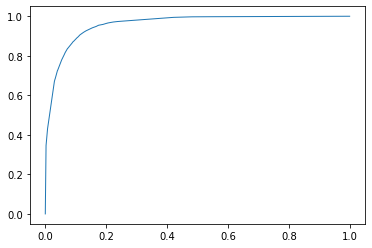

使用逻辑回归训练原始数据集的结果
auc值为
 0.9239646884707894


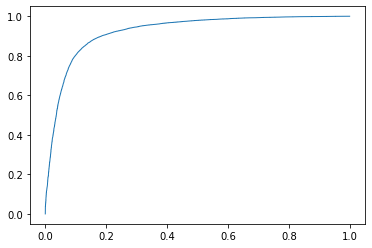

In [1]:
import numpy as np # 快速操作结构数组的工具
import matplotlib.pyplot as plt  # 可视化绘制
from sklearn.linear_model import LinearRegression  # 线性回归
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.preprocessing import OneHotEncoder


# 弱分类器的数目
n_estimator = 10
# 随机生成分类数据。
X, y = make_classification(n_samples=80000,n_features=20,n_classes=2)

# 切分为测试集和训练集，比例0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# 将训练集切分为两部分，一部分用于训练GBDT模型，另一部分输入到训练好的GBDT模型生成GBDT特征，然后作为LR的特征。这样分成两部分是为了防止过拟合。
X_train_gbdt, X_train_lr, y_train_gbdt, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)
# 调用GBDT分类模型。
gbdt = GradientBoostingClassifier(n_estimators=n_estimator)
# 调用one-hot编码。
one_hot = OneHotEncoder()
# 调用LR分类模型。
lr = LogisticRegression()


'''使用X_train训练GBDT模型，后面用此模型构造特征'''
gbdt.fit(X_train_gbdt, y_train_gbdt)

X_leaf_index = gbdt.apply(X_train_gbdt)[:, :, 0]  # apply返回每个样本在每科树中所属的叶子节点索引。行数为样本数，列数为树数目。值为在每个数的叶子索引
X_lr_leaf_index = gbdt.apply(X_train_lr)[:, :, 0] # apply返回每个样本在每科树中所属的叶子节点索引。行数为样本数，列数为树数目。值为在每个数的叶子索引
print('每个样本在每个树中所属的叶子索引\n',X_leaf_index)
# fit one-hot编码器
one_hot.fit(X_leaf_index)  # 训练one-hot编码，就是识别每列有多少可取值
X_lr_one_hot = one_hot.transform(X_lr_leaf_index)  # 将训练数据，通过gbdt树，形成的叶子节点（每个叶子代表了原始特征的一种组合）索引，编码成one0-hot特征。
# 编码后的每个特征代表原来的一批特征的组合。

''' 
使用训练好的GBDT模型构建特征，然后将特征经过one-hot编码作为新的特征输入到LR模型训练。
'''

# 使用lr训练gbdt的特征组合
print('使用逻辑回归训练GBDT组合特征的结果')
lr.fit(X_lr_one_hot, y_train_lr)
# 用训练好的LR模型多X_test做预测
y_pred_grd_lm = lr.predict_proba(one_hot.transform(gbdt.apply(X_test)[:, :, 0]))[:, 1]  # 获取测试集正样本的概率
# 根据预测结果输出
fpr, tpr, thresholds = roc_curve(y_test, y_pred_grd_lm)  # 获取真正率和假正率以及门限
roc_auc = auc(fpr, tpr)
print('auc值为\n',roc_auc)
#画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来
plt.plot(fpr, tpr, lw=1, label='area = %0.2f' %  roc_auc)
plt.show()



# 使用lr直接训练原始数据
print('使用逻辑回归训练原始数据集的结果')
lr.fit(X_train_lr, y_train_lr)
# 用训练好的LR模型多X_test做预测
y_pred_grd_lm = lr.predict_proba(X_test)[:, 1]  # 获取测试集正样本的概率
# 根据预测结果输出
fpr, tpr, thresholds = roc_curve(y_test, y_pred_grd_lm)  # 获取真正率和假正率以及门限
roc_auc = auc(fpr, tpr)
print('auc值为\n',roc_auc)
#画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来
plt.plot(fpr, tpr, lw=1, label='area = %0.2f' %  roc_auc)
plt.show()

我们可以看到结果
每个样本在每个树中所属的叶子索引

 [[  3.   3.   3. ...,   3.   3.   3.]
 
 [  7.   7.   7. ...,   4.   7.   4.]
 
 [ 14.  14.  14. ...,  14.  14.  14.]
 
 ..., 
 [ 14.  14.  14. ...,  13.  13.  14.]
 
 [ 14.  14.  14. ...,  14.  14.  14.]
 
 [ 14.  14.  13. ...,  13.  13.  14.]]
 
使用逻辑回归训练GBDT组合特征的结果

auc值为

 0.976446818947
 
使用逻辑回归训练原始数据集的结果

auc值为

 0.960063847564

效果提取了1.5%。

CTR预估中GBDT和LR的融合
----------------

在CTR预估中，如何利用ad_id是一个问题。

直接将ad_id作为特征建树不可行，而one-hot编码过于稀疏，为每个ad_id建GBDT树，相当于发掘出区分每个广告的特征。

而对于曝光不充分的样本即长尾部分，无法单独建树。

综合方案为：使用GBDT对非ID和ID分别建一类树。

非ID类树：

不以细粒度的ID建树，此类树作为base，即这些ID一起构建GBDT。

即便曝光少的广告、广告主，仍可以通过此类树得到有区分性的特征、特征组合。

ID类树：

以细粒度 的ID建一类树（每个ID构建GBDT），用于发现曝光充分的ID对应有区分性的特征、特征组合。

如何根据GBDT建的两类树，对原始特征进行映射？

以如下图为例，当一条样本x进来之后，遍历两类树到叶子节点，得到的特征作为LR的输入。当AD曝光不充分不足以训练树时，其它树恰好作为补充。

方案如图：

![x](https://img-blog.csdnimg.cn/d5ac576e44fe47358cc8e881157c82ed.png)

其中kaggle竞赛一般树的数目最多为30，通过GBDT转换得到特征空间相比于原始ID低了很多。

总结
--

对于样本量大的数据，线性模型具有训练速度快的特点，但线性模型学习能力限于线性可分数据，所以就需要特征工程将数据尽可能地从输入空间转换到线性可分的特征空间。

GBDT与LR的融合模型，其实使用GBDT来发掘有区分度的特征以及组合特征，来替代人工组合特征。工业种GBDT+LR、GBDT+FM都是应用比较广泛。